L'objectif de ce notebook est de créer un outil permettant d'éviter le lancement d'une évaluation en important les informations d'un log de screen.



In [117]:
import re

re_epoch = re.compile(r"Finished epoch \[\d+\] in \[(\d+\.?\d*)\] secs")
re_finish = re.compile(r"Finished training in \[(\d+\.?\d*)\]")
      
model = []                 

def parse_model(file, model):
    with open(file) as f:
        current = None
        testing = False
        for line in f:
            stripped = line.strip()
            if stripped.startswith("modelname: "):
                current = stripped[len("modelname: "):]
                model.append({
                    "tar": "",
                    "epochs": [],
                    "scores": {
                        # "taskname": {
                            # "all/unknown/ambiguous": {"precision": 0., "accuracy": 0, etc.} 
                        # }
                    }
                })
                continue
            # If we do not have a current model
            if not current:
                continue
            # Get the model tar exported
            if stripped.startswith("Saved best model to: ["):
                model[-1]["tar"] = stripped[len("Saved best model to: ["):-1]
                continue
            # Get the time of each epoch
            epoch = re_epoch.findall(stripped)
            if epoch:
                model[-1]["epochs"].append(float(epoch[0]))
                continue
            # Get the finished time
            finished = re_finish.findall(stripped)
            if finished:
                model[-1]["time"] = float(finished[0])
            if "Bye!" == stripped:
                current = None
                testing = False
                print(model[-1])

            # Parsing test results

            if stripped == "Evaluating model on test set":
                testing = True
                current_category = ""
                headers = []
                continue
            if testing:
                # If the line starts with "## ", we are testing a category
                if stripped.startswith("## "):
                    current_category = stripped[len("## "):]
                    model[-1]["scores"][current_category] = {}
                    headers = []
                    continue
                # On the contrary, if it starts with "|" we are in a table
                if stripped.startswith("|") and current_category:
                    # We split around "|" and remove the first and last value, which are empty values
                    real_rows = [val.strip() for val in stripped.split("|")[1:-1]]
                    if re.match("-+", real_rows[0]):
                        continue
                    if not headers:
                        headers = real_rows[1:]
                        continue
                    model[-1]["scores"][current_category][real_rows[0]] = dict(zip(headers, real_rows[1:]))
    return model

model = parse_model("../../../LASLA/percent_log.log", model)
model = parse_model("../../../LASLA/percent_0075.log", model)
        
                

{'tar': './models/model-percent-0,01--lemma-2020_03_19-14_42_57.tar', 'epochs': [6.90581, 7.27924, 6.58057, 7.05972, 6.99085], 'scores': {'lemma': {'all': {'accuracy': '0.0', 'precision': '0.0', 'recall': '0.0', 'support': '172968'}, 'unknown-tokens': {'accuracy': '0.0', 'precision': '0.0', 'recall': '0.0', 'support': '60801'}, 'ambiguous-tokens': {'accuracy': '0.0', 'precision': '0.0', 'recall': '0.0', 'support': '10759'}, 'unknown-targets': {'accuracy': '0.0', 'precision': '0.0', 'recall': '0.0', 'support': '23011'}}, 'pos': {'all': {'accuracy': '0.0299', 'precision': '0.0061', 'recall': '0.0327', 'support': '172968'}, 'unknown-tokens': {'accuracy': '0.001', 'precision': '0.0004', 'recall': '0.0374', 'support': '60801'}, 'ambiguous-tokens': {'accuracy': '0.0275', 'precision': '0.007', 'recall': '0.0474', 'support': '22988'}}, 'Gend': {'all': {'accuracy': '0.7543', 'precision': '0.1078', 'recall': '0.1429', 'support': '172968'}, 'unknown-tokens': {'accuracy': '0.7163', 'precision': '0

In [118]:
tasks = list(model[0]["scores"].keys())
# We iterate over tasks and do not use set(list()) to keep the original order of the different categories
categories = []
for task in tasks:
    for cat in model[0]["scores"][task]:
        if cat not in categories:
            categories.append(cat)
metrics = list(model[0]["scores"][tasks[0]][categories[0]].keys())

print("Tasks", tasks)
print("Categories", categories)
print("Metrics", metrics)

Tasks ['lemma', 'pos', 'Gend']
Categories ['all', 'unknown-tokens', 'ambiguous-tokens', 'unknown-targets']
Metrics ['accuracy', 'precision', 'recall', 'support']


In [119]:
def clean_model_name(model_tar):
    return model_tar.split("--")[0].split("/")[-1]

clean_model_name(model[0]["tar"])

header = ["Model"] + ["_".join([task, cat, metric]) for task in tasks for cat in categories for metric in ["accuracy", "precision", "support"]]
rows = [header]
for m in model:
    rows.append([clean_model_name(m["tar"])])
    for head in header[1:]:
        task, cat, metric = head.split("_")
        if cat in m["scores"][task]:
            rows[-1].append(m["scores"][task][cat][metric])
        else:
            rows[-1].append("NaN")

In [120]:
import csv

with open("out-percent.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  del sys.path[0]


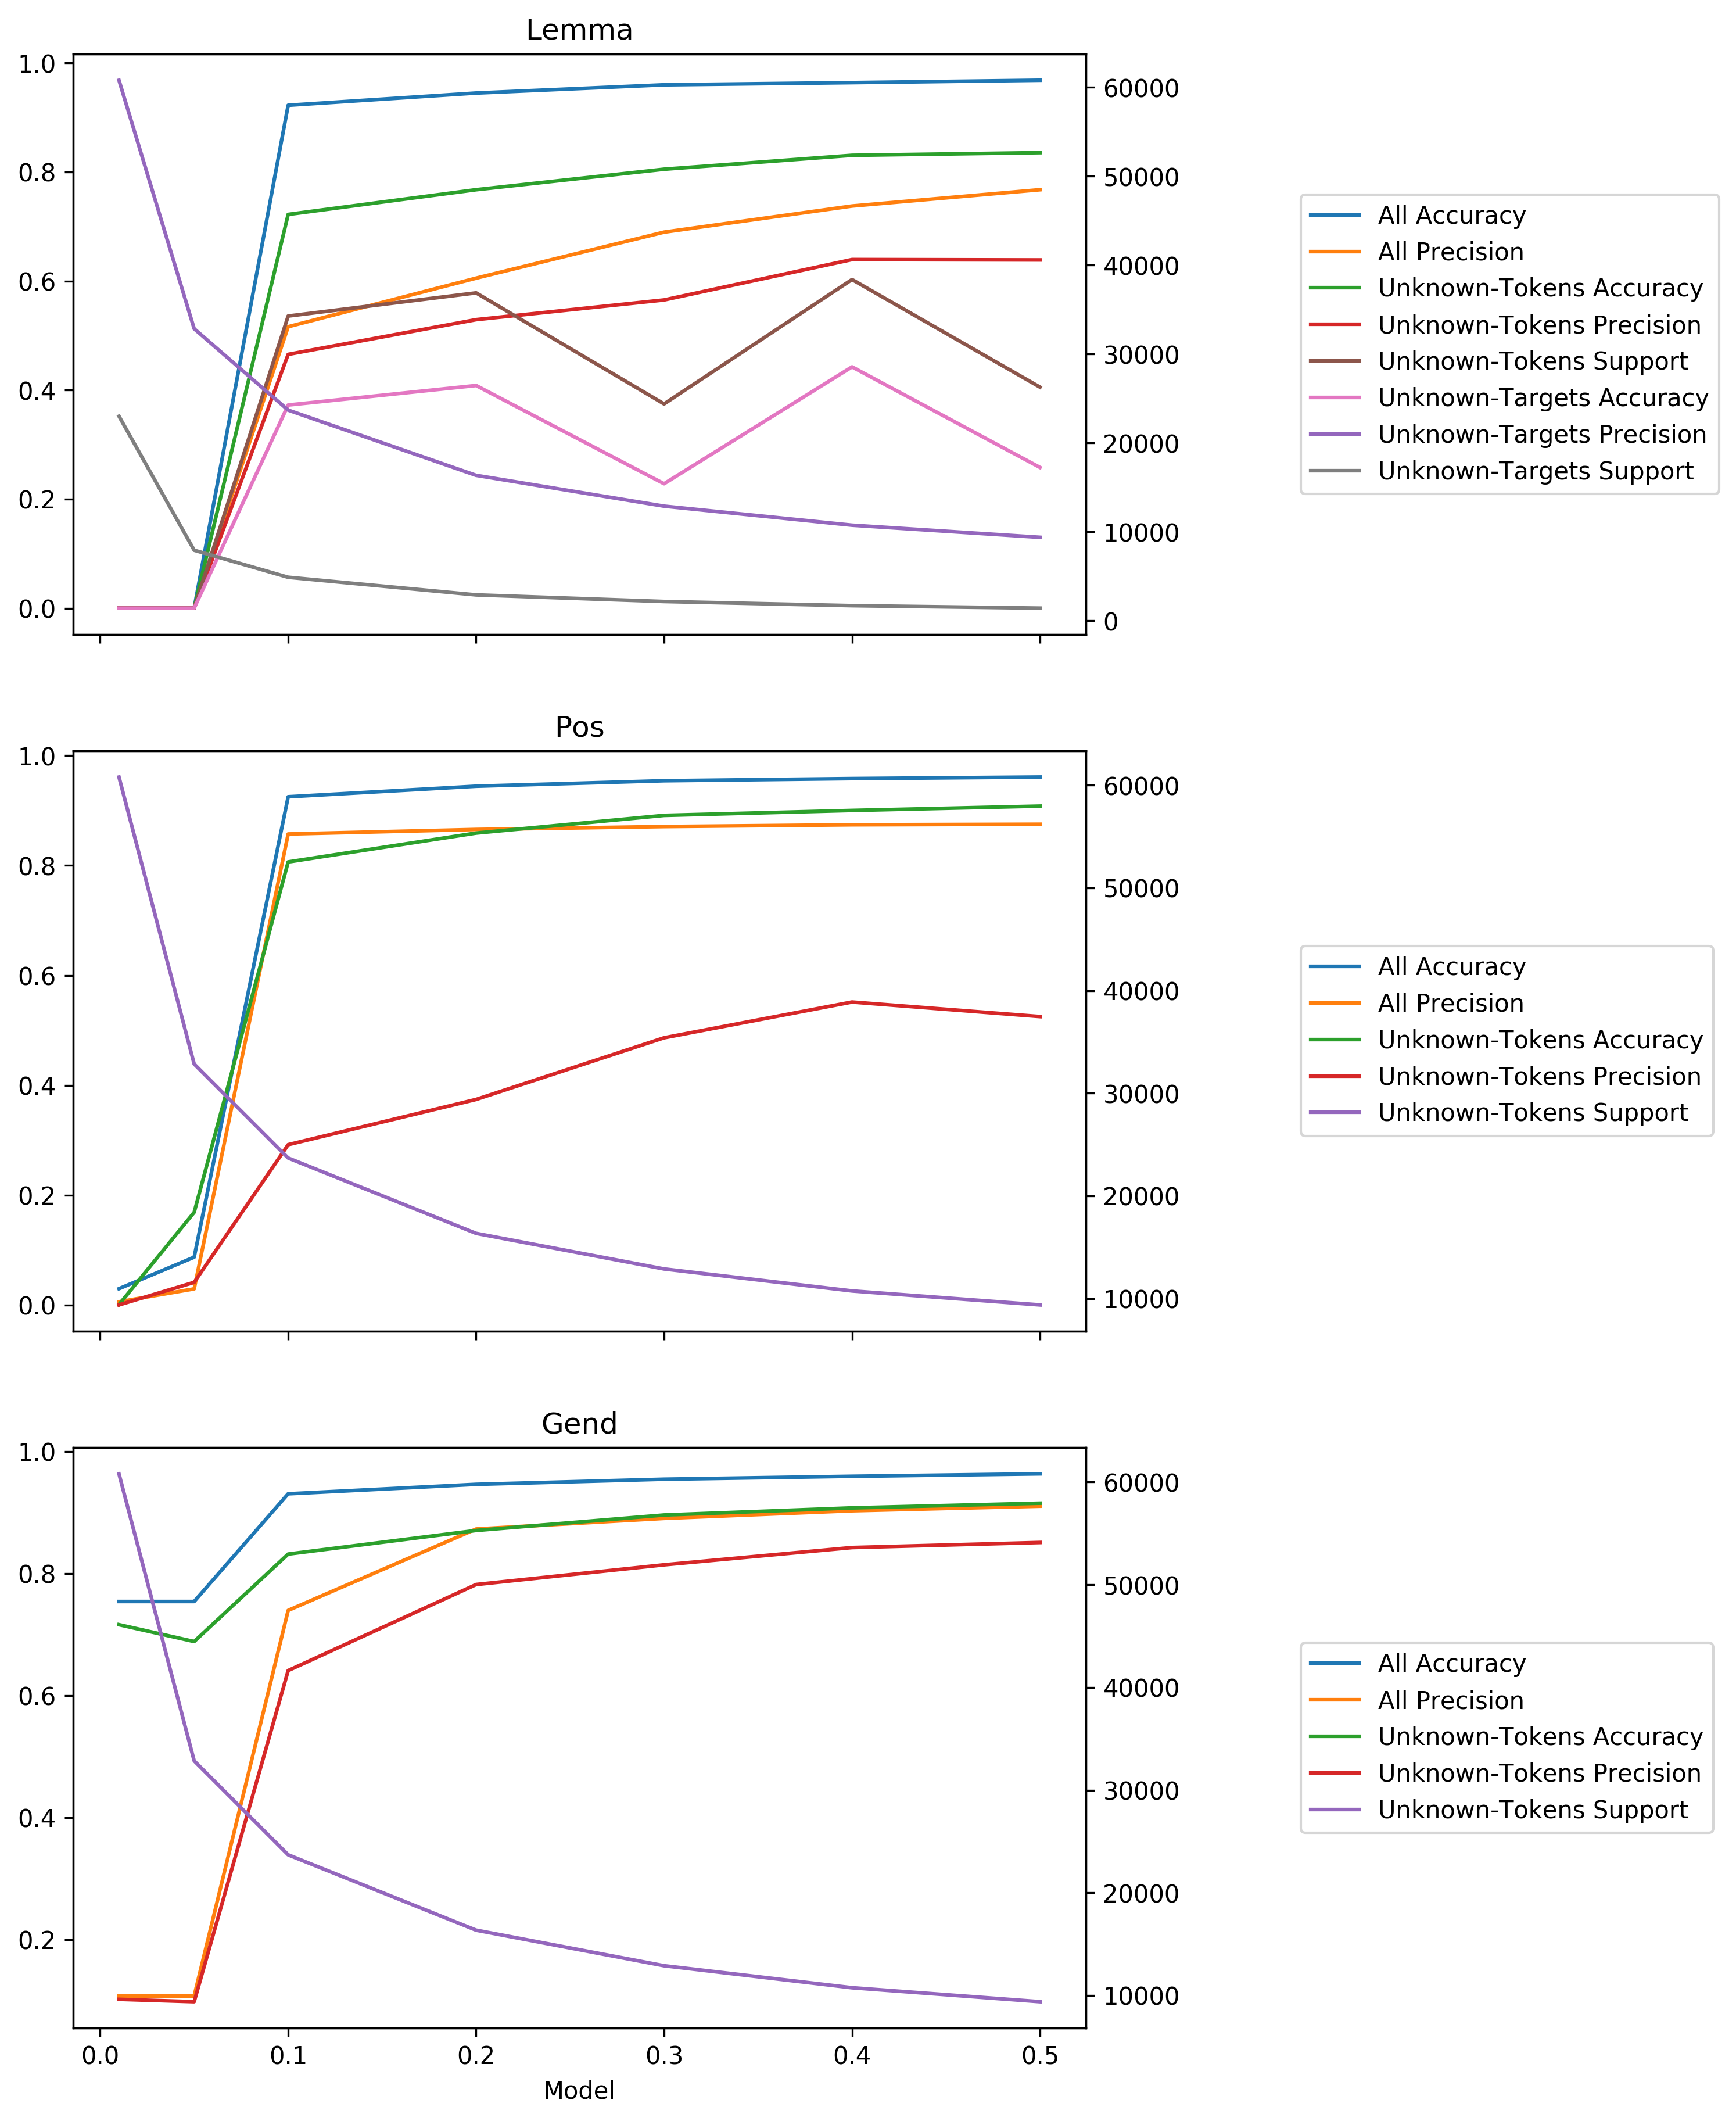

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=3)
fig.set_size_inches(7.5, 15, forward=True)
fig.set_dpi(300)
fig.patch.set_facecolor('xkcd:white')


df = pd.DataFrame.from_csv("/home/thibault/CloudStation/Thèse/Modeles/Tableaux/Pourcentages-Architecture-Complexe.csv")

ax = None

def filter_columns(column_name) -> bool:
    if "Support" in column_name and "All" in column_name:
        return True
    return False

drawn_cats = []
legends = []
for column in df.columns:
    secondary_y = "Support" in column
    _cat = column.split()[0]
    if _cat not in drawn_cats:
        drawn_cats.append(_cat)
        legends.append([])
    
    ax = axes[drawn_cats.index(_cat)]
    ax.set_title(_cat)
    
    # We skip all information
    if filter_columns(column):
        continue
        
    legends[-1].append(" ".join(column.split()[1:]))
    df.plot(y=[column], secondary_y=secondary_y, ax=ax)
    
for legend, ax in zip(legends, axes):
    box = ax.get_position()
    # Do twice because we got two y axes
    ax.set_position(
        [box.x0, box.y0, box.width * 0.5, box.height],
        [box.x0, box.y0, box.width * 0.5, box.height]
    )
    # Put a legend to the right of the current axis
    lines = ax.get_lines() + ax.right_ax.get_lines()
    ax.legend(lines, legend, loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=1)